In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [4]:
#creating whole dataset
seventeen = pd.read_json("https://missingmigrants.iom.int/global-figures/2017/json")
sixteen = pd.read_json("https://missingmigrants.iom.int/global-figures/2016/json")
fifteen = pd.read_json("https://missingmigrants.iom.int/global-figures/2015/json")
fourteen = pd.read_json("https://missingmigrants.iom.int/global-figures/2014/json")

In [5]:
frames = [seventeen,sixteen,fifteen,fourteen]
df = pd.concat(frames)

In [6]:
#cleaning data
df = df.replace('', 0,regex=True)
df = df.replace('nan', 0, regex=True)
df.drop(['Information Source'])
df = df[df['Web ID'] != 42424] #drops row with -1 as number of survivors

df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['total people'] = pd.to_numeric(df['Number of survivors']) + pd.to_numeric(df['Total Dead and Missing'])
df['percent female'] = (pd.to_numeric(df['Number of Female'])/ df['total people']).fillna(0)
df['percent male'] =  (pd.to_numeric(df['Number of Male'])/ df['total people']).fillna(0)
df['percent kids'] =  (pd.to_numeric(df['Number of Children']) / df['total people']).fillna(0)
df['month'] = df['Reported Date'].dt.month
df['day'] = df['Reported Date'].dt.day

#latitude and longitude to cartesian
R = 6371
df['x'] = df['Location'].apply(lambda latLong: R*math.cos(float(latLong.split(", ")[0]))*math.cos(float(latLong.split(", ")[1])))
df['y'] = df['Location'].apply(lambda latLong: R*math.cos(float(latLong.split(", ")[0]))*math.sin(float(latLong.split(", ")[1])))
df['z'] = df['Location'].apply(lambda latLong: R*math.sin(float(latLong.split(", ")[0])))

In [54]:
#separating data
# fourteen = df[(df['Reported Date'] >= '2014-01-01') & (df['Reported Date'] < '2015-01-01')]
# fifteen = df[(df['Reported Date'] >= '2015-01-01') & (df['Reported Date'] < '2016-01-01')]
# sixteen = df[(df['Reported Date'] >= '2016-01-01') & (df['Reported Date'] < '2017-01-01')]
# seventeen = df[(df['Reported Date'] >= '2017-01-01') & (df['Reported Date'] < '2018-01-01')]

In [55]:
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit

In [56]:
def linear(dataframe):
    # the index will help us get back from number to category later
    dataframe['UNSD Geographical Grouping'], geoIndex = pd.Series(dataframe['UNSD Geographical Grouping']).factorize()
    dataframe['Migrant Route'], migrantIndex = pd.Series(dataframe['Migrant Route']).factorize()
    dataframe['Region of Incident'], regionIndex = pd.Series(dataframe['Region of Incident']).factorize()

    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0
    
    y = (100*y).astype(int)


    x = np.array(dataframe[['UNSD Geographical Grouping', 'Migrant Route', 'Region of Incident', 'percent female',
                     'percent kids', 'percent male', 'month', 'day']])
    x = np.nan_to_num(x)

    x[:,3] = (100*x[:,3]).astype(int)
    x[:,4] = (100*x[:,4]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)


    rs = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

    for train_index, test_index in rs.split(x):
        regr = linear_model.LinearRegression()
        regr.fit(x[train_index],y[train_index])
        print("train: ", regr.score(x[train_index],y[train_index]) )
        print("test: ", regr.score(x[test_index],y[test_index]))
    print()

In [60]:
def nn(dataframe):
    # the index will help us get back from number to category later
    dataframe['UNSD Geographical Grouping'], geoIndex = pd.Series(dataframe['UNSD Geographical Grouping']).factorize()
    dataframe['Migrant Route'], migrantIndex = pd.Series(dataframe['Migrant Route']).factorize()
    dataframe['Region of Incident'], regionIndex = pd.Series(dataframe['Region of Incident']).factorize()

    y = np.array((pd.to_numeric(dataframe['Number of survivors']) / dataframe['total people']).fillna(0))
    y = np.nan_to_num(y)
    y[y == np.abs(np.inf)] = 0
    
    y = (100*y).astype(int)


    x = np.array(dataframe[['UNSD Geographical Grouping', 'Migrant Route', 'Region of Incident', 'percent female',
                     'percent kids', 'percent male', 'month', 'day']])
    x = np.nan_to_num(x)

    x[:,3] = (100*x[:,3]).astype(int)
    x[:,4] = (100*x[:,4]).astype(int)
    x[:,2] = (100*x[:,2]).astype(int)


#     rs = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

#     for train_index, test_index in rs.split(x):
#         regr = linear_model.LinearRegression()
#         regr.fit(x[train_index],y[train_index])
#         print("train: ", regr.score(x[train_index],y[train_index]) )
#         print("test: ", regr.score(x[test_index],y[test_index]))
#     print()
    
    ntr = len(y)//4 *3
    x_tr = x[:ntr,:]
    y_tr = y[:ntr]
    x_ts = x[ntr:,:]
    y_ts = y[ntr:]

    K.clear_session()

    nin = x.shape[1]
    nout = int(np.max(y)+1) 
    model = Sequential()
    model.add(Dense(100, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='softmax', name='output'))

    model.summary()

    opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_tr, y_tr, epochs=10, batch_size=100, validation_data=(x_ts,y_ts))
    return model,x_tr,y_tr,x_ts,y_ts

In [57]:
linearFrame = df.copy(deep=True) #as to keep same df for later use

linear(linearFrame) #.2
linear(linearFrame[linearFrame['UNSD Geographical Grouping'] == geoIndex.get_loc('Central America')]) #.41

C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply


train:  0.189575694258
test:  0.173185902101
train:  0.181848515751
test:  0.191545532187
train:  0.181317381178
test:  0.200121181546

train:  0.328144743217
test:  0.414092450658
train:  0.391303557173
test:  0.160383453985
train:  0.366127206034
test:  0.318608173157



C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [61]:
nnFrame = df.copy(deep=True) #as to keep same df for later use
nnModel,x_tr,y_tr,x_ts,y_ts = nn(nnFrame)

C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 100)               10100     
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________
Train on 2391 samples, validate on 800 samples
Epoch 1/10
2391/2391 [==============================] - 2s 694us/step - loss: 3.7279 - acc: 0.3149 - val_loss: 2.5929 - val_acc: 0.8300
Epoch 2/10
2391/2391 [==============================] - 0s 182us/step - loss: 1.6695 - acc: 0.8628 - val_loss: 1.3265 - val_acc: 0.8300
Epoch 3/10
2391/2391 [==============================] - 0s 209us/step - loss: 1.0010 - acc: 0.8628 - val_loss: 1.1655 - val_acc: 0.8300
Epoch 4/10
2391/2391 [==============================] - 0s 189us/step - loss: 0

In [56]:
yp = nnModel.predict(x_ts)

In [57]:
yp.shape

(800, 100)

In [7]:
import keras
from keras.models import Model,Sequential
from keras.layers import Dense,Activation
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras import optimizers

Using TensorFlow backend.


In [45]:
# def neural(dataframe):
dataframe df.copy(deep=True)
ohc_UNSD = pd.get_dummies(dataframe['UNSD Geographical Grouping'],prefix='UNSD')
ohc_Route = pd.get_dummies(dataframe['Migrant Route'],prefix='Route')
ohc_Region = pd.get_dummies(dataframe['Region of Incident'],prefix='Region')

#makes a copy of dataframe,  does not alter it
frame = dataframe.join(ohc_UNSD)
frame = frame.join(ohc_Region)
frame = frame.join(ohc_Route)

y = np.array((pd.to_numeric(frame['Number of survivors']) / frame['total people']).fillna(0))
y = np.nan_to_num(y)
y[y == np.abs(np.inf)] = 0

b = (100*y).astype(int)


x = np.array(frame[['percent female', 'percent kids', 'percent male', 'day','month','x','y','z']])
x = np.column_stack((x,np.array(frame.loc[:,'UNSD_0':])))

x = np.nan_to_num(x)
x[:,0] = (100*x[:,0]).astype(int)
x[:,1] = (100*x[:,1]).astype(int)
x[:,2] = (100*x[:,2]).astype(int)


SyntaxError: invalid syntax (<ipython-input-45-2b8bfe927916>, line 2)

In [ ]:
ntr = len(y)//4 *3
x_tr = x[:ntr,:]
y_tr = y[:ntr]
x_ts = x[ntr:,:]
y_ts = y[ntr:]

K.clear_session()

nin = x.shape[1]
nout = int(np.max(y)+1) 
model = Sequential()
model.add(Dense(100, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

model.summary()

opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_tr, y_tr, epochs=10, batch_size=100, validation_data=(x_ts,y_ts))

In [9]:
# neural(df)

C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
C:\Users\kimmy\Miniconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               5700      
_________________________________________________________________
output (Dense)               (None, 100)               10100     
Total params: 15,800
Trainable params: 15,800
Non-trainable params: 0
_________________________________________________________________
Train on 82317 samples, validate on 27442 samples
Epoch 1/10
82317/82317 [==============================] - 14s 175us/step - loss: 1.1260 - acc: 0.8115 - val_loss: 1.1626 - val_acc: 0.8507
Epoch 2/10
82317/82317 [==============================] - 13s 161us/step - loss: 0.8206 - acc: 0.8377 - val_loss: 1.2649 - val_acc: 0.8507
Epoch 3/10
82317/82317 [==============================] - 14s 165us/step - loss: 0.7478 - acc: 0.8375 - val_loss: 1.3234 - val_acc: 0.8507
Epoch 4/10
82317/82317 [==============================] - 14s 168us

array([[  9.61321652e-01,   7.16299496e-07,   1.32766766e-08, ...,
          3.06240562e-03,   3.16649297e-04,   1.41191634e-03],
       [  9.61710572e-01,   7.02403611e-07,   1.31067921e-08, ...,
          3.04382667e-03,   3.07429349e-04,   1.38284580e-03],
       [  9.61956501e-01,   6.93624145e-07,   1.29988438e-08, ...,
          3.03194881e-03,   3.01652268e-04,   1.36449654e-03],
       ..., 
       [  5.71449041e-01,   1.20806840e-06,   2.20633498e-10, ...,
          2.30919309e-02,   8.33330024e-03,   1.60663333e-02],
       [  8.04447174e-01,   6.74074181e-05,   6.10160305e-06, ...,
          2.39852946e-02,   6.90907566e-03,   1.16449147e-02],
       [  9.81507182e-01,   9.75295507e-07,   3.34852990e-09, ...,
          3.08734318e-03,   1.00880978e-03,   1.58879708e-03]], dtype=float32)

In [14]:
y_pred = model.predict(x_ts)

In [16]:
y_pred.shape

(27442, 100)

In [17]:
y_ts.shape

(27442,)

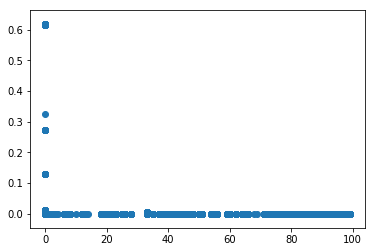

In [33]:
plt.scatter(y_ts,y_pred[:,9])
plt.show()

In [34]:
x_ts.shape

(27442, 56)

In [42]:
y_ts.shape

(27442,)

In [46]:
y.shape

(109759,)

In [47]:
x.shape

(109759, 56)

In [49]:
np.array((pd.to_numeric(df['Number of survivors']) / df['total people']).fillna(0)).shape

(3191,)